In [1]:
from IPython.display import clear_output

In [2]:
!pip install statsmodels
clear_output(wait=True)
print("statsmodels installed")
!pip install sklearn
clear_output(wait=True)
print("sklearn installed")

sklearn installed


In [3]:
import pathlib
from tqdm import tqdm
import tqdm
import pandas as pd
import pickle as pkl
import numpy as np

import xarray as xr
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy
import scipy.stats as st
import os
import copy
import sys
# Import these costom functions from the toolbox
sys.path.insert(1, './tools/')
import metrics
import signatures
import analysis_tools

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [4]:
# NOTEBOOK SETUP.
# CHOSE OPTIONS, PATHS, DATE RANGES, ETC. HERE IN THIS CELL

# Options for what to calculate
# Calulations will be saved to pkl
# If False, will load in pkl files
######################################
calculate_metric_dictionary = True #
calculate_flow_categories = True   #
calculate_metric_matrix = True     #
######################################

val_start='10/01/1989'
val_end='09/30/1999'
date_range = pd.date_range(start=val_start, end=val_end)

# Specifics about the analysis to use. 
all_metrics = ['NSE', 'Alpha-NSE', 'Pearson-r', 'Beta-NSE', 'FHV', 'FMS', 'FLV', 'Peak-Timing']
use_metrics = ['NSE', 'Beta-NSE', 'Peak-Timing']
metric_names = ['Nash-Sutcliffe Efficiency', 'Total bias', 'Peak timing error']
short_metric_names = ['NSE', 'Bias', 'Timing']
use_metric_names = ['Nash-Sutcliffe Efficiency', 'Total bias', 'Peak timing error']
use_metric_locs = [0,3,7]
# Plotting parameters for the metrics defined above.
disp_bounds = [(-0,1), (-0.2,0.1), (0,2)]
diff_bounds = [1, 0.2, 2]
optimal = [1, 0, 0]
disp_colors = {'base_model':'PRGn', 'lagged_streamflow_both':'PRGn'} 

# local directory with all data
# not included in github
data_dir = "./data/"
run_dir = "/home/NearingLab/projects/jmframe/lstm-da/runs/time_split/"

In [5]:
if False: # Open the attributes set up to do regression
    openthis = data_dir+'camels_attributes_v2.0/camels_attributes_v2.0_Regression.csv'
    attributes = pd.read_csv(openthis, sep=',', index_col='gauge_id')
else: # Open a slightly more extrnsive data set.
    openthis = data_dir+'camels_attributes_v2.0/camels_attributes_v2.0.csv'
    attributes = pd.read_csv(openthis, sep=';', index_col='gauge_id')

# Catchment attributes and hydrologic signatures that are not useful
drop_these = ['high_prec_timing','root_depth_50', 'root_depth_99','zero_q_freq','water_frac','organic_frac',
              'low_prec_timing', 'geol_1st_class','dom_land_cover','other_frac']
    
# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
attributes['basin_id_str'] = basin_id_str

# These are bad for the regression analysis.
attributes = attributes.drop(drop_these, axis=1)
df = copy.deepcopy(attributes)
df = df.dropna(axis=1)

In [6]:
# Get the hydrologic units for each basin.
with open(data_dir + 'usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
attributes['basin_hydro_unit'] = basin_hydro_unit

In [10]:
results = {}

sim_dir = "simulation/simulation_seed_0_1304_224615/test/model_epoch030/"
sim_file = "test_results.p"
da_dir = "assimilation/assimilation_seed_0_holdout_0.0_lead_2/test/model_epoch030/"
da_file = "test_results_data_assimilation.p"
ar_dir = "autoregression/autoregression_lead_1_train_holdout_0.5_test_holdout_0.0_seed_0/test/model_epoch030/"
ar_file = "test_results.p"
run_dir_file_dict = {"sim":run_dir+sim_dir+sim_file, "da":run_dir+da_dir+da_file, "ar":run_dir+ar_dir+ar_file}

for run_type in run_dir_file_dict.keys():
    with open(run_dir_file_dict[run_type], "rb") as fb:
        results[run_type] = pkl.load(fb)


In [11]:
static_attributes = ['elev_mean','slope_mean','area_gages2',
'frac_forest','lai_max','lai_diff','gvf_max',
'gvf_diff','soil_depth_pelletier','soil_depth_statsgo','soil_porosity',
'soil_conductivity','max_water_content','sand_frac','silt_frac','clay_frac',
'carbonate_rocks_frac','geol_permeability','p_mean','pet_mean','aridity',
'frac_snow','high_prec_freq','high_prec_dur','low_prec_freq','low_prec_dur']


In [12]:
basin_list = results['sim'].keys()

In [13]:
plot_lats = []
plot_lons = []
for i, b in enumerate(basin_list):
    plot_lats.append(attributes.loc[int(b),'gauge_lat'])
    plot_lons.append(attributes.loc[int(b),'gauge_lon'])
plot_lats = np.array(plot_lats)
plot_lons = np.array(plot_lons)

In [14]:
df = df.set_index('basin_id_str').loc[basin_list,:]

In [15]:
df['nse_sim'] = np.nan
df['nse_ar'] = np.nan
df['nse_da'] = np.nan
df['nse_ar-sim'] = np.nan
df['nse_da-sim'] = np.nan
df['nse_da-ar'] = np.nan

In [16]:
for basin in basin_list:
#     df['nse_sim'] = metrics.nse(results['sim'][basin]['1D']['xr']['QObs(mm/d)_obs'], 
#                                 results['sim'][basin]['1D']['xr']['QObs(mm/d)_sim'])
    df.loc[basin,'nse_sim'] = results['sim'][basin]['1D']['NSE']
    df.loc[basin,'nse_ar'] = results['ar'][basin]['1D']['NSE']
    df.loc[basin,'nse_da'] = results['da'][basin]['1D']['NSE']
    df.loc[basin,'nse_ar-sim'] = results['ar'][basin]['1D']['NSE'] - results['sim'][basin]['1D']['NSE']
    df.loc[basin,'nse_da-sim'] = results['da'][basin]['1D']['NSE'] - results['sim'][basin]['1D']['NSE']
    df.loc[basin,'nse_da-ar'] = results['da'][basin]['1D']['NSE'] - results['ar'][basin]['1D']['NSE']

In [17]:
results['sim'][basin]['1D']

{'xr': <xarray.Dataset>
 Dimensions:         (date: 3652, time_step: 1)
 Coordinates:
   * date            (date) datetime64[ns] 1989-10-01 1989-10-02 ... 1999-09-30
   * time_step       (time_step) int64 0
 Data variables:
     QObs(mm/d)_obs  (date, time_step) float32 0.3069 0.279 ... 0.1848 0.1848
     QObs(mm/d)_sim  (date, time_step) float32 0.4262 0.3333 ... 0.253 0.2428,
 'NSE': 0.8971898555755615,
 'KGE': 0.9133684323589238,
 'Alpha-NSE': 1.0641372251010823,
 'Beta-NSE': 0.020862837562767703}

In [18]:
results['da'][basin]['1D']

{'xr': <xarray.Dataset>
 Dimensions:         (date: 3652, time_step: 1)
 Coordinates:
   * date            (date) datetime64[ns] 1989-10-01 1989-10-02 ... 1999-09-30
   * time_step       (time_step) int64 0
 Data variables:
     QObs(mm/d)_obs  (date, time_step) float32 0.3069 0.279 ... 0.1848 0.1848
     QObs(mm/d)_sim  (date, time_step) float32 0.4262 0.3333 ... 0.1862 0.1763,
 'NSE': 0.9059344232082367,
 'KGE': 0.9527285225711403,
 'Alpha-NSE': 1.0069223135831429,
 'Beta-NSE': -0.00158212139804317}

In [19]:
df

,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,low_prec_freq,low_prec_dur,glim_1st_class_frac,...,slope_mean,area_gages2,area_geospa_fabric,baseflow_index,nse_sim,nse_ar,nse_da,nse_ar-sim,nse_da-sim,nse_da-ar
basin_id_str,,,,,,,,,,,,,,,,,,,,,
01022500,3.608126,2.119256,-0.114530,0.245259,0.587356,20.55,1.205279,233.65,3.662226,0.590658,...,17.79072,573.60,620.38,0.554478,0.858931,0.960366,0.932700,0.101435,0.073769,-0.027666
01031500,3.522957,2.071324,0.104091,0.291836,0.587950,18.90,1.148936,227.35,3.473644,0.448928,...,29.56035,769.05,766.53,0.445091,0.896980,0.950614,0.913708,0.053634,0.016728,-0.036906
01047000,3.323146,2.090024,0.147776,0.280118,0.628929,20.10,1.165217,235.90,3.691706,0.308488,...,49.92122,909.10,904.94,0.473465,0.859059,0.919627,0.894835,0.060569,0.035776,-0.024792
01052500,3.730858,2.096423,0.152097,0.352698,0.561914,13.50,1.129707,193.50,2.896707,0.497458,...,60.05183,383.82,396.10,0.459700,0.871757,0.928358,0.892425,0.056601,0.020668,-0.035932
01054200,4.067132,2.128355,0.104960,0.299642,0.523306,17.50,1.194539,220.30,3.263704,0.871443,...,90.13951,180.98,181.33,0.437050,0.772115,0.827564,0.794405,0.055448,0.022290,-0.033159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14309500,4.977781,3.122204,-0.995847,0.061255,0.627228,15.10,1.776471,222.65,6.893189,0.863563,...,110.42527,224.92,226.31,0.459455,0.885777,0.918714,0.896061,0.032937,0.010285,-0.022652
14316700,4.543400,2.277630,-0.821172,0.176337,0.501305,14.75,1.446078,214.85,6.018207,0.444680,...,119.08920,587.90,588.01,0.508616,0.911744,0.950213,0.918165,0.038469,0.006421,-0.032048
14325000,6.297437,2.434652,-0.952055,0.030203,0.386610,14.60,1.467337,219.05,6.240741,0.903702,...,124.96889,443.07,444.92,0.480769,0.928631,0.947802,0.929350,0.019170,0.000719,-0.018451


In [20]:
df.columns.values[:-6]

array(['p_mean', 'pet_mean', 'p_seasonality', 'frac_snow', 'aridity',
       'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur',
       'glim_1st_class_frac', 'glim_2nd_class_frac',
       'carbonate_rocks_frac', 'geol_permeability', 'frac_forest',
       'lai_max', 'lai_diff', 'gvf_max', 'gvf_diff',
       'dom_land_cover_frac', 'soil_depth_pelletier',
       'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity',
       'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac',
       'gauge_lat', 'gauge_lon', 'elev_mean', 'slope_mean', 'area_gages2',
       'area_geospa_fabric', 'baseflow_index'], dtype=object)

In [21]:
# Multi-linear Regression in a K-fold loop
def cross_val_lr(X,y,feature_list,kf,ynormal=False, title='scatterplottitle', corr_matrix=None):

    if len(feature_list_short) > 1:
        index_labs = feature_list_short
    else:
        index_labs = feature_list
    feature_importances = pd.DataFrame(index=index_labs, columns=['total_importance'])
    for iF, F in enumerate(feature_importances.index.values):
        feature_importances.loc[F, 'total_importance'] = 0
    
    rmse_list = []
    r2_list = []
    y_hat_list = []
    y_test_list = []
    y_hat_indx_list = []
    
    fig, ax = plt.subplots(figsize=(6.5,8.04))
    grid = plt.GridSpec(2, 3, wspace=0.33333)
    plt.subplot(grid[0, :2])
    for train_index, test_index in kf.split(X):
                
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_hat = lr.predict(X_test)

        # Get numerical feature importances
        importances = list(lr.coef_)
        for iF, F in enumerate(feature_importances.index.values):
            feature_importances.loc[F, 'total_importance'] += importances[iF]
        
        rmse = np.sqrt(np.mean(np.power((y_test - y_hat),2)))
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, y_hat)
        r2 = r_value**2        
#        plt.scatter(y_test,y_hat, c='b')
        
        rmse_list.append(rmse)
        r2_list.append(r2)
        y_hat_list.extend(y_hat)
        y_test_list.extend(y_test)
        y_hat_indx_list.extend(test_index)
    
    feature_importances.loc[:, 'total_importance'] = feature_importances.loc[:, 'total_importance'] / \
                                                     kf.get_n_splits()


    y_hat_all = sort_list(y_hat_list, y_hat_indx_list)
    
    #############       Positive or Negative color coded importances
    if corr_matrix is not None:
        bar_colorz=[]
        bar_labelz=[]
        for feature_importance in feature_importances.index.values:
            if corr_matrix.loc[feature_importance]>0:
                bar_colorz.append('b')
                bar_labelz.append('positive')
            elif corr_matrix.loc[feature_importance]<0:
                bar_colorz.append('r')
                bar_labelz.append('negative')
            else:
                bar_colorz.append('black')
                bar_labelz.append('noncorrelated')
    else:
        #############        Do a regular linear regression, so we know if the correlation is Positive or Negative
        lr = LinearRegression()
        lr.fit(X, y)
        linear_coefficients = lr.coef_
        print(lr.predict)
        slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, lr.predict())
        print('multi-linear regression r2:', overall_r_value)
        bar_colorz=list(np.where(lr.coef_>0, 'b', 'r'))
        bar_labelz=list(np.where(lr.coef_>0, 'positive', 'negative'))
    feature_importances.loc[:, 'bar_colorz'] = bar_colorz
    feature_importances.loc[:, 'bar_labelz'] = bar_labelz
    feature_importances = feature_importances.sort_values('total_importance', ascending=False)
    #############       Positive or Negative color coded importances
    
    overall_rmse = np.sqrt(np.mean(np.power((y - y_hat_all),2)))
    slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, y_hat_all)
    overall_r2_value = overall_r_value**2
    print('Overall rmse for the out-of-sample predictions: {:.2f}'.format(overall_rmse))
    print('Overall r^2 for the out-of-sample predictions: {:.2f}'.format(overall_r_value**2))
    print("RMSE Value stats for cross validation")
    print_stats(rmse_list)
    print("R-squared Value stats for cross validation")
    print_stats(r2_list)
    x=np.linspace(np.min(y), np.max(y), num=2)
    omax = np.max([np.max(y), np.max(y_hat_all)])
    omin = np.min([np.min(y), np.min(y_hat_all)])
    
    plt.scatter(y_test_list,y_hat_list, c='b', label='r2 = {:.2f}'.format(np.nanmean(np.array(r2_list))))
    plt.title(title)
    plt.xlabel("true target values")
    plt.ylabel("predicted values")
    
    plt.xlim([omin,omax])
    plt.ylim([omin,omax])
    plt.plot(x, x*slope+intercept, label='slope:{:.2f}, intercept:{:.2f}'.format(slope,intercept))
    plt.plot([omin, omax],[omin, omax],'--',c='k',label='1 to 1 line')
    plt.grid()
    plt.legend()
    
    plt.subplot(grid[1, :])
    plt.bar(feature_importances.index.values,
            feature_importances.total_importance,
            color=feature_importances.bar_colorz,
            label=feature_importances.bar_labelz)
    
    # --------------   This is a hack to get the legend to show the color groups #-----#
    colors = {'negative correlation':'red', 'positive correlation':'blue'}       #-----#
    labels = list(colors.keys())                                                 #-----#
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]#-----#
    plt.legend(handles, labels)                                                  #-----#
    # --------------   This is a hack to get the legend to show the color groups #-----#

    plt.ylabel('feature importance')
    plt.xticks(rotation=90)
#    plt.grid()

    grid.tight_layout(fig)
    plt.show()
    plt.close()    

    return y_hat_all, overall_rmse, overall_r2_value, feature_importances

In [22]:
# Random Forest Regression in a K-fold loop
def cross_val_rf(X,y,feature_list,kf,ynormal=False,
                 n_estimators=10,random_state=42,
                 criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                 min_weight_fraction_leaf=0, feature_list_short=[], title='scatterplottitle', filename=None,
                 corr_matrix=None):

    if len(feature_list_short) > 1:
        index_labs = feature_list_short
    else:
        index_labs = feature_list
    feature_importances = pd.DataFrame(index=index_labs, columns=['total_importance'])
    for iF, F in enumerate(feature_importances.index.values):
        feature_importances.loc[F, 'total_importance'] = 0
    
    rmse_list = []
    r2_list = []
    y_hat_list = []
    y_test_list = []
    y_hat_indx_list = []
    
    fig, ax = plt.subplots(figsize=(6.5,8.04))
    grid = plt.GridSpec(2, 3, wspace=0.33333)
    plt.subplot(grid[0, :2])
    for train_index, test_index in kf.split(X):
                
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                  criterion=criterion, min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, max_depth=max_depth,
                                  min_weight_fraction_leaf=min_weight_fraction_leaf)
        rf.fit(X_train, y_train);
        y_hat = rf.predict(X_test)

        # Get numerical feature importances
        importances = list(rf.feature_importances_)
        for iF, F in enumerate(feature_importances.index.values):
            feature_importances.loc[F, 'total_importance'] += importances[iF]
        
        rmse = np.sqrt(np.mean(np.power((y_test - y_hat),2)))
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, y_hat)
        r2 = r_value**2        
#        plt.scatter(y_test,y_hat, c='b')
        
        rmse_list.append(rmse)
        r2_list.append(r2)
        y_hat_list.extend(y_hat)
        y_test_list.extend(y_test)
        y_hat_indx_list.extend(test_index)
    
    feature_importances.loc[:, 'total_importance'] = feature_importances.loc[:, 'total_importance'] / \
                                                     kf.get_n_splits()

    print(feature_importances)
    
    y_hat_all = sort_list(y_hat_list, y_hat_indx_list)
    
    #############       Positive or Negative color coded importances
    if corr_matrix is not None:
        bar_colorz=[]
        bar_labelz=[]
        for feature_importance in feature_importances.index.values:
            if corr_matrix.loc[feature_importance]>0:
                bar_colorz.append('b')
                bar_labelz.append('positive')
            elif corr_matrix.loc[feature_importance]<0:
                bar_colorz.append('r')
                bar_labelz.append('negative')
            else:
                bar_colorz.append('black')
                bar_labelz.append('noncorrelated')
    else:
        #############        Do a regular linear regression, so we know if the correlation is Positive or Negative
        lr = LinearRegression()
        lr.fit(X, y)
        linear_coefficients = lr.coef_
        print(lr.predict)
        slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, lr.predict())
        print('multi-linear regression r2:', overall_r_value)
        bar_colorz=list(np.where(lr.coef_>0, 'b', 'r'))
        bar_labelz=list(np.where(lr.coef_>0, 'positive', 'negative'))
    feature_importances.loc[:, 'bar_colorz'] = bar_colorz
    feature_importances.loc[:, 'bar_labelz'] = bar_labelz
    feature_importances = feature_importances.sort_values('total_importance', ascending=False)
    #############       Positive or Negative color coded importances
    
    overall_rmse = np.sqrt(np.mean(np.power((y - y_hat_all),2)))
    slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, y_hat_all)
    overall_r2_value = overall_r_value**2
    print('Overall rmse for the out-of-sample predictions: {:.2f}'.format(overall_rmse))
    print('Overall r^2 for the out-of-sample predictions: {:.2f}'.format(overall_r_value**2))
    print("RMSE Value stats for cross validation")
    print_stats(rmse_list)
    print("R-squared Value stats for cross validation")
    print_stats(r2_list)
    x=np.linspace(np.min(y), np.max(y), num=2)
    omax = np.max([np.max(y), np.max(y_hat_all)])
    omin = np.min([np.min(y), np.min(y_hat_all)])
    
    plt.scatter(y_test_list,y_hat_list, c='b', label='r2 = {:.2f}'.format(np.nanmean(np.array(r2_list))))
    plt.title(title)
    plt.xlabel("true target values")
    plt.ylabel("predicted values")
    
    plt.xlim([omin,omax])
    plt.ylim([omin,omax])
    plt.plot(x, x*slope+intercept, label='slope:{:.2f}, intercept:{:.2f}'.format(slope,intercept))
    plt.plot([omin, omax],[omin, omax],'--',c='k',label='1 to 1 line')
    plt.grid()
    plt.legend()
    
    plt.subplot(grid[1, :])
    plt.bar(feature_importances.index.values,
            feature_importances.total_importance,
            color=feature_importances.bar_colorz,
            label=feature_importances.bar_labelz)
    
    # --------------   This is a hack to get the legend to show the color groups #-----#
    colors = {'negative correlation':'red', 'positive correlation':'blue'}       #-----#
    labels = list(colors.keys())                                                 #-----#
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]#-----#
    plt.legend(handles, labels)                                                  #-----#
    # --------------   This is a hack to get the legend to show the color groups #-----#

    plt.ylabel('feature importance')
    plt.xticks(rotation=90)
#    plt.grid()

    grid.tight_layout(fig)
    plt.show()
    if filename:
        fig.savefig(filename+'.pdf', dpi=300)
        fig.savefig(filename+'.png', dpi=300)
    plt.close()    

    return y_hat_all, overall_rmse, overall_r2_value, feature_importances

In [23]:
# Set the training and targets.
def set_X_y(df, regressor_attributes, target, xnormal=False, ynormal=False, xlog=False, ylog=False):
    X=np.array(df.loc[:,regressor_attributes])
    y=np.array(df[target])
    X_krig=np.array(df.loc[:,['gauge_lat', 'gauge_lon']])

    if ynormal:
        y_mean = np.nanmean(y)
        y_std = np.nanstd(y)
        y = (y-y_mean)/y_std
    
    if xnormal:
        for i, r in enumerate(regressor_attributes):
            iX = np.array(df.loc[:,r])
            X_mean = np.nanmean(iX)
            X_std = np.nanstd(iX)
            X[:,i] = (iX - X_mean) / X_std
    
    if xlog:
        for i, r in enumerate(regressor_attributes):
            for iX in range(X.shape[0]):
                if np.abs(np.log(np.array(df.iloc[iX,i]))) > 0:
                    X[iX] = np.log(np.array(df.iloc[iX,i]))
    if ylog:
        for iy in range(y.shape[0]):
            if np.abs(np.log(y[iy])) > 0:
                y[iy] = np.log(y[iy])
        
    return X, y

In [24]:
def sort_list(list1, list2): 
    zipped_pairs = zip(list2, list1) 
    z = [x for _, x in sorted(zipped_pairs)] 
    return z
def print_stats(d):
    print("mean = {:.2f},  median = {:.2f}, stdev = {:.2f}, min = {:.2f}, max = {:.2f}".format(
        np.nanmean(np.array(d)),
        np.nanmedian(np.array(d)),
        np.nanstd(np.array(d)),
        np.nanmin(np.array(d)),
        np.nanmax(np.array(d))
        )
    )

In [25]:
corr_matrix = df.corr().iloc[:,-6:]

/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in

                     total_importance
elev_mean                    0.023267
slope_mean                   0.044368
area_gages2                  0.020578
frac_forest                  0.210062
lai_max                      0.021827
lai_diff                     0.015345
gvf_max                      0.028359
gvf_diff                     0.016967
soil_depth_pelletier         0.047517
soil_depth_statsgo           0.011468
soil_porosity                0.019668
soil_conductivity            0.018111
max_water_content             0.02847
sand_frac                    0.031729
silt_frac                    0.023966
clay_frac                    0.034622
carbonate_rocks_frac         0.011781
geol_permeability            0.044233
p_mean                       0.037272
pet_mean                     0.053833
aridity                      0.055754
frac_snow                    0.077775
high_prec_freq               0.018823
high_prec_dur                 0.02675
low_prec_freq                0.043357
low_prec_dur

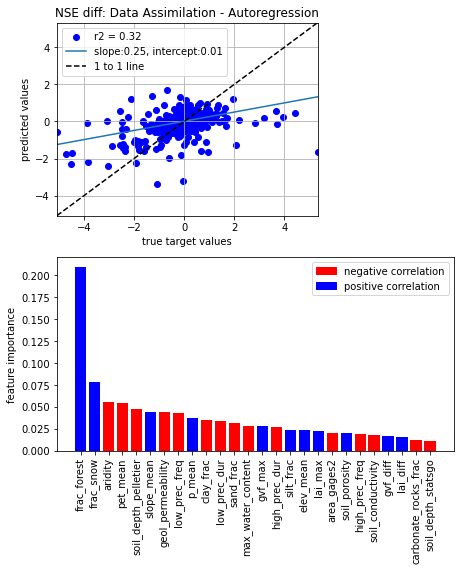

/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in

                     total_importance
elev_mean                    0.023764
slope_mean                   0.048598
area_gages2                  0.020617
frac_forest                  0.195083
lai_max                      0.018816
lai_diff                     0.018458
gvf_max                      0.028009
gvf_diff                     0.017391
soil_depth_pelletier         0.052169
soil_depth_statsgo           0.011057
soil_porosity                0.020385
soil_conductivity            0.020208
max_water_content            0.032403
sand_frac                    0.035789
silt_frac                    0.023123
clay_frac                    0.031191
carbonate_rocks_frac         0.014571
geol_permeability            0.045945
p_mean                       0.042545
pet_mean                     0.051876
aridity                      0.052801
frac_snow                    0.068654
high_prec_freq               0.018374
high_prec_dur                0.029645
low_prec_freq                 0.04476
low_prec_dur

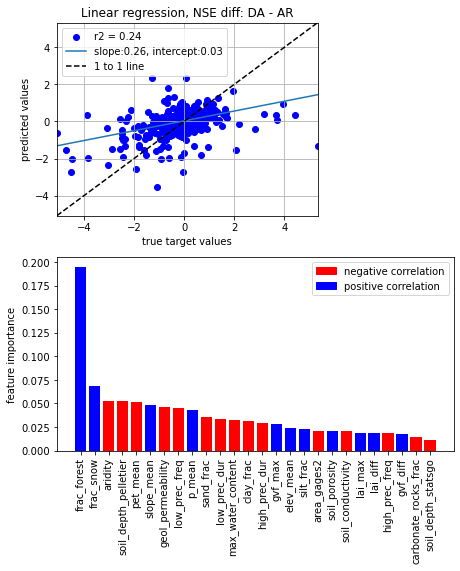

In [26]:
regressor_attributes = static_attributes#df.columns.values[:-6]

target='nse_da-ar'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE diff: Data Assimilation - Autoregression', 
                filename='corr_diff_da_ar', corr_matrix=corr_matrix[target])

y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,ynormal=ynormal,
                                                  title='Linear regression, NSE diff: DA - AR',
                                                   corr_matrix=corr_matrix[target])

/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in

                     total_importance
elev_mean                    0.016299
slope_mean                   0.033807
area_gages2                  0.016343
frac_forest                  0.023967
lai_max                      0.023831
lai_diff                     0.036254
gvf_max                      0.018215
gvf_diff                     0.029029
soil_depth_pelletier         0.033319
soil_depth_statsgo           0.011371
soil_porosity                0.025541
soil_conductivity            0.041067
max_water_content             0.02249
sand_frac                    0.036743
silt_frac                    0.023064
clay_frac                    0.024737
carbonate_rocks_frac         0.012258
geol_permeability            0.037103
p_mean                       0.240758
pet_mean                     0.039907
aridity                      0.043853
frac_snow                    0.072097
high_prec_freq               0.095414
high_prec_dur                0.013589
low_prec_freq                0.014498
low_prec_dur

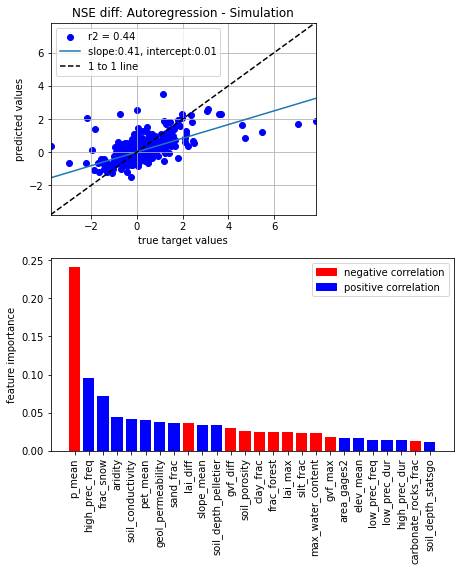

/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in

                     total_importance
elev_mean                    0.017228
slope_mean                   0.024099
area_gages2                  0.017006
frac_forest                  0.022717
lai_max                      0.023773
lai_diff                     0.039412
gvf_max                      0.015305
gvf_diff                     0.028515
soil_depth_pelletier         0.031533
soil_depth_statsgo           0.011379
soil_porosity                0.025938
soil_conductivity            0.045567
max_water_content            0.023145
sand_frac                    0.039014
silt_frac                    0.019263
clay_frac                    0.023203
carbonate_rocks_frac         0.010882
geol_permeability            0.034208
p_mean                       0.244914
pet_mean                     0.042683
aridity                      0.057999
frac_snow                    0.071543
high_prec_freq               0.087706
high_prec_dur                 0.01278
low_prec_freq                0.013433
low_prec_dur

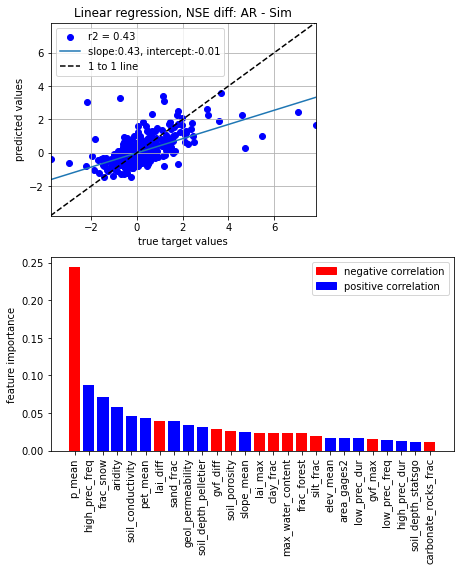

In [27]:
regressor_attributes = static_attributes#df.columns.values[:-6]

target='nse_ar-sim'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE diff: Autoregression - Simulation',
                filename='corr_diff_ar_sim', corr_matrix=corr_matrix[target])
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,ynormal=ynormal,
                                                   title='Linear regression, NSE diff: AR - Sim', 
                                                   corr_matrix=corr_matrix[target])


/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in

                     total_importance
elev_mean                    0.060112
slope_mean                   0.036036
area_gages2                  0.016424
frac_forest                  0.030668
lai_max                      0.016899
lai_diff                     0.015782
gvf_max                      0.013116
gvf_diff                     0.014483
soil_depth_pelletier         0.043892
soil_depth_statsgo           0.019508
soil_porosity                0.017476
soil_conductivity            0.025155
max_water_content            0.021923
sand_frac                    0.021588
silt_frac                    0.020751
clay_frac                    0.038965
carbonate_rocks_frac         0.020956
geol_permeability            0.028019
p_mean                       0.081683
pet_mean                     0.019678
aridity                      0.052749
frac_snow                    0.134442
high_prec_freq                0.18912
high_prec_dur                0.018172
low_prec_freq                0.023672
low_prec_dur

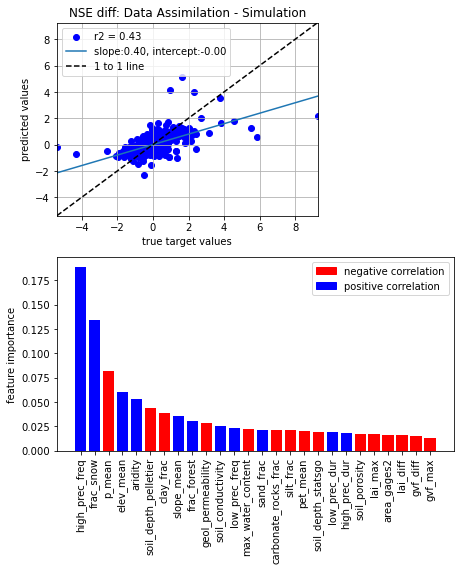

/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in

                     total_importance
elev_mean                    0.065835
slope_mean                   0.035608
area_gages2                  0.016086
frac_forest                  0.026764
lai_max                      0.022307
lai_diff                     0.015846
gvf_max                      0.012396
gvf_diff                     0.013698
soil_depth_pelletier         0.042577
soil_depth_statsgo           0.019077
soil_porosity                0.020325
soil_conductivity            0.027741
max_water_content             0.02194
sand_frac                    0.019888
silt_frac                    0.021968
clay_frac                    0.040814
carbonate_rocks_frac         0.020805
geol_permeability            0.028032
p_mean                       0.081837
pet_mean                     0.021871
aridity                      0.059984
frac_snow                     0.12746
high_prec_freq               0.177378
high_prec_dur                 0.01649
low_prec_freq                0.023199
low_prec_dur

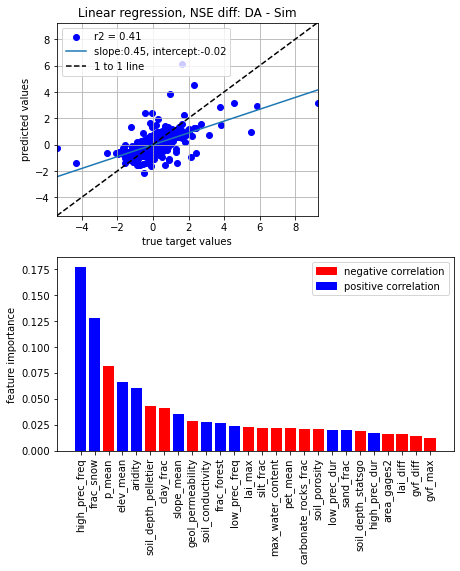

In [29]:
regressor_attributes = static_attributes#df.columns.values[:-6]

target='nse_da-sim'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE diff: Data Assimilation - Simulation',
                filename='corr_diff_da_sim', corr_matrix=corr_matrix[target])
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,ynormal=ynormal,
                                                   title='Linear regression, NSE diff: DA - Sim', 
                                                   corr_matrix=corr_matrix[target])


/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in

                     total_importance
elev_mean                    0.019262
slope_mean                   0.066433
area_gages2                    0.0514
frac_forest                  0.106225
lai_max                      0.017378
lai_diff                     0.012122
gvf_max                      0.029563
gvf_diff                     0.018701
soil_depth_pelletier         0.025649
soil_depth_statsgo           0.011967
soil_porosity                 0.02224
soil_conductivity            0.012235
max_water_content             0.01293
sand_frac                    0.014269
silt_frac                    0.031069
clay_frac                    0.020161
carbonate_rocks_frac         0.009338
geol_permeability            0.020771
p_mean                         0.0892
pet_mean                     0.027952
aridity                      0.070526
frac_snow                    0.025156
high_prec_freq               0.058524
high_prec_dur                0.024972
low_prec_freq                 0.18734
low_prec_dur

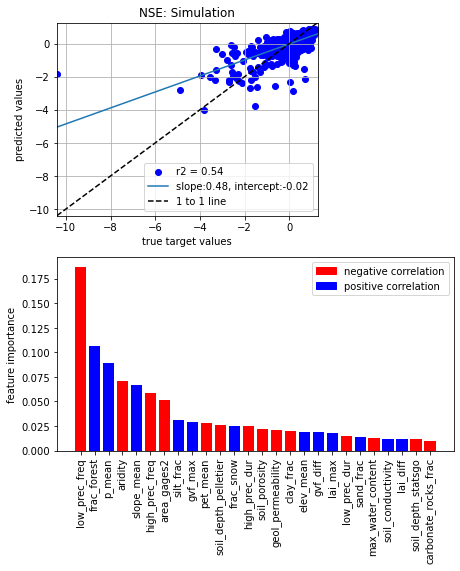

/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in

                     total_importance
elev_mean                    0.020102
slope_mean                   0.065716
area_gages2                  0.053718
frac_forest                  0.099204
lai_max                       0.01571
lai_diff                     0.011483
gvf_max                      0.029292
gvf_diff                      0.01695
soil_depth_pelletier         0.032252
soil_depth_statsgo            0.00984
soil_porosity                0.021858
soil_conductivity            0.011359
max_water_content            0.012961
sand_frac                    0.016529
silt_frac                    0.030142
clay_frac                    0.017657
carbonate_rocks_frac         0.007409
geol_permeability            0.019656
p_mean                        0.08435
pet_mean                     0.022497
aridity                      0.103758
frac_snow                     0.02692
high_prec_freq               0.064773
high_prec_dur                0.020981
low_prec_freq                0.171438
low_prec_dur

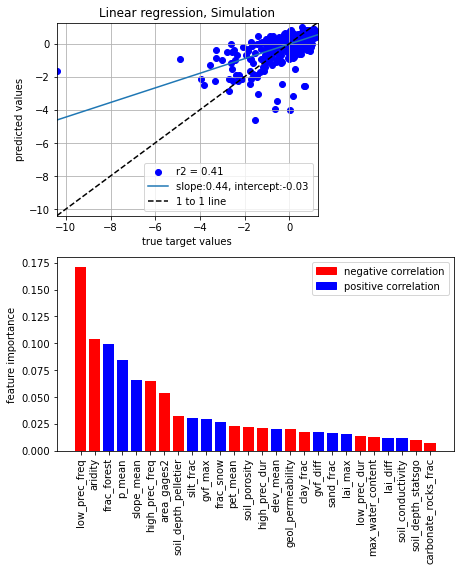

In [30]:
# Make a dictionary for all the X, y values
regressor_attributes = static_attributes#df.columns.values[:-6]
feature_list_short = []
target='nse_sim'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE: Simulation',
                filename='corr_simulation', corr_matrix=corr_matrix[target])
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,ynormal=ynormal,
                                                   title='Linear regression, Simulation', 
                                                   corr_matrix=corr_matrix[target])


/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in

                     total_importance
elev_mean                    0.024448
slope_mean                    0.07586
area_gages2                  0.046678
frac_forest                  0.149821
lai_max                      0.026425
lai_diff                     0.013465
gvf_max                      0.026077
gvf_diff                     0.011377
soil_depth_pelletier         0.042998
soil_depth_statsgo           0.007184
soil_porosity                0.019918
soil_conductivity            0.030632
max_water_content             0.01271
sand_frac                    0.025664
silt_frac                    0.026892
clay_frac                    0.026336
carbonate_rocks_frac         0.005378
geol_permeability            0.019334
p_mean                       0.021131
pet_mean                     0.018606
aridity                      0.055893
frac_snow                    0.084761
high_prec_freq               0.029755
high_prec_dur                0.017998
low_prec_freq                0.161092
low_prec_dur

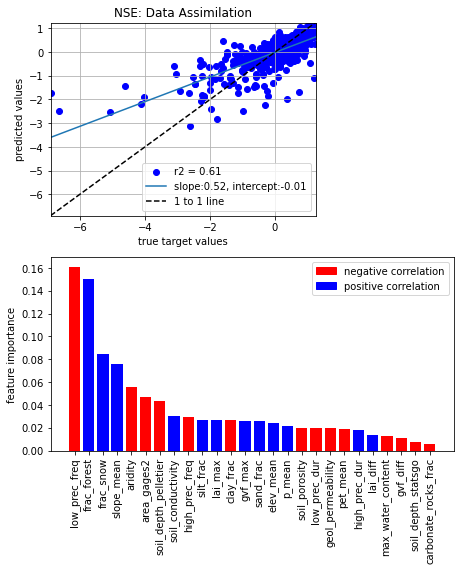

/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in

                     total_importance
elev_mean                    0.025099
slope_mean                   0.084292
area_gages2                  0.045267
frac_forest                  0.137783
lai_max                      0.022865
lai_diff                     0.012832
gvf_max                      0.018669
gvf_diff                     0.012103
soil_depth_pelletier         0.052061
soil_depth_statsgo           0.005784
soil_porosity                0.018141
soil_conductivity            0.028532
max_water_content            0.011059
sand_frac                    0.022574
silt_frac                    0.027223
clay_frac                    0.027652
carbonate_rocks_frac         0.006393
geol_permeability            0.018374
p_mean                       0.022666
pet_mean                     0.019192
aridity                      0.059424
frac_snow                    0.075964
high_prec_freq               0.027241
high_prec_dur                0.018918
low_prec_freq                0.180682
low_prec_dur

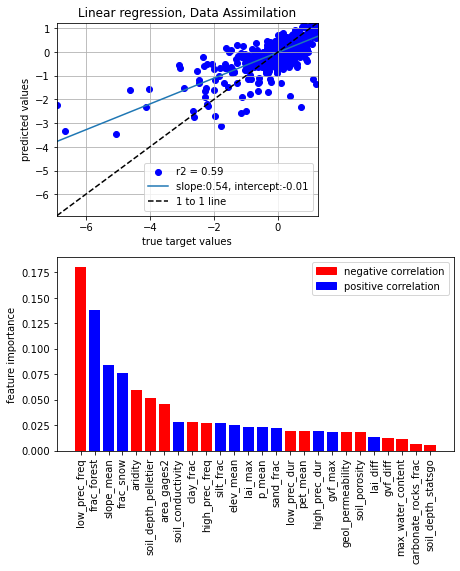

In [31]:
# Make a dictionary for all the X, y values
regressor_attributes = static_attributes#df.columns.values[:-6]

feature_list_short = []
target='nse_da'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE: Data Assimilation',
                filename='corr_data_assimilation', corr_matrix=corr_matrix[target])
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,ynormal=ynormal,
                                                   title='Linear regression, Data Assimilation', 
                                                   corr_matrix=corr_matrix[target])


/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in

                     total_importance
elev_mean                    0.019491
slope_mean                   0.052546
area_gages2                  0.064105
frac_forest                  0.039128
lai_max                      0.031866
lai_diff                     0.033922
gvf_max                      0.019101
gvf_diff                      0.01746
soil_depth_pelletier         0.030583
soil_depth_statsgo           0.008931
soil_porosity                0.019583
soil_conductivity            0.041125
max_water_content            0.017566
sand_frac                    0.020313
silt_frac                    0.024291
clay_frac                    0.027322
carbonate_rocks_frac         0.006874
geol_permeability            0.021675
p_mean                       0.017602
pet_mean                     0.027451
aridity                      0.040386
frac_snow                    0.132792
high_prec_freq               0.058602
high_prec_dur                0.026788
low_prec_freq                0.184774
low_prec_dur

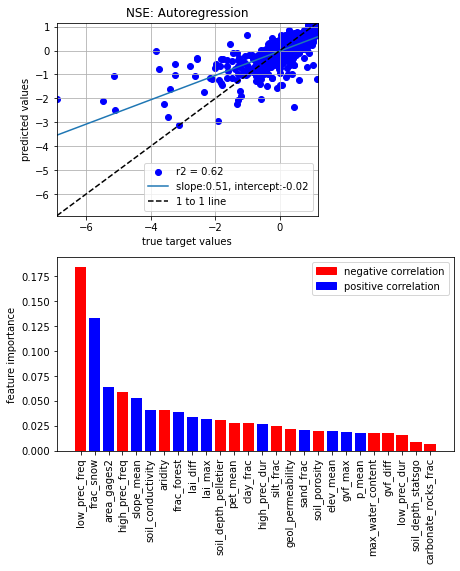

/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in

                     total_importance
elev_mean                    0.023605
slope_mean                   0.055672
area_gages2                  0.065718
frac_forest                  0.042765
lai_max                      0.022955
lai_diff                     0.032426
gvf_max                      0.027928
gvf_diff                     0.019937
soil_depth_pelletier         0.030786
soil_depth_statsgo           0.008606
soil_porosity                0.017596
soil_conductivity            0.037294
max_water_content            0.018419
sand_frac                    0.021568
silt_frac                    0.022976
clay_frac                    0.026796
carbonate_rocks_frac         0.007654
geol_permeability            0.023086
p_mean                       0.018368
pet_mean                     0.025805
aridity                      0.043252
frac_snow                    0.125683
high_prec_freq               0.061074
high_prec_dur                 0.02397
low_prec_freq                 0.17706
low_prec_dur

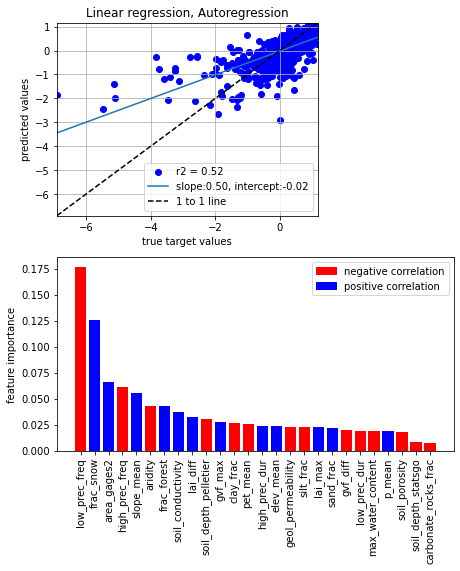

In [32]:
# Make a dictionary for all the X, y values
regressor_attributes = static_attributes#df.columns.values[:-6]

feature_list_short = []
target='nse_ar'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE: Autoregression',
                filename='corr_autoregression', corr_matrix=corr_matrix[target])
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,ynormal=ynormal,
                                                   title='Linear regression, Autoregression', 
                                                   corr_matrix=corr_matrix[target])


/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


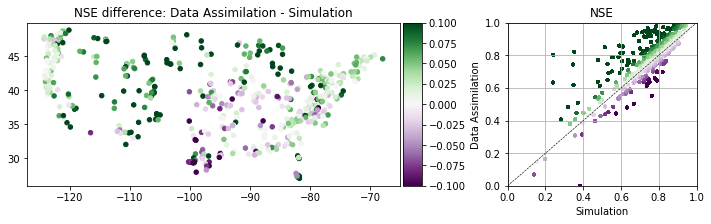

/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


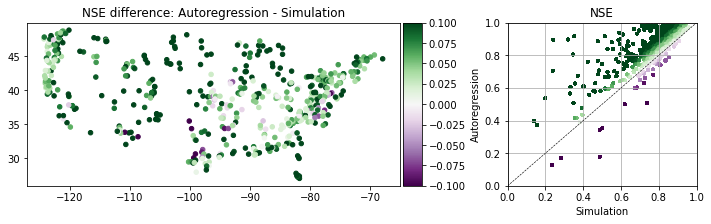

In [33]:

test_model_label_map = {'nse_da':'Data Assimilation', 'nse_ar':'Autoregression'}

for test_model in ['nse_da', 'nse_ar']:
    
    gs = plt.GridSpec(1, 10, wspace=0.33333)
    fig = plt.figure(figsize=(12, 3))
    ax0 = fig.add_subplot(gs[0,:6])
    im = ax0.scatter(plot_lons, plot_lats,
                    c=df.loc[:,test_model+'-sim'],
                    s=20,
                    cmap='PRGn',
                    vmin=-.1, vmax=.1)
    ax0.set_title('NSE difference: {} - Simulation'.format(test_model_label_map[test_model]))
    clims = im.get_clim()

    # colorbar
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax1 = fig.add_subplot(gs[0,7:])
    ax1.plot([0, 1],[0,1], 'k--', lw=0.6)
    for b, basin in enumerate(basin_list):
        basin_color = im.to_rgba(df.loc[:,test_model+'-sim'])
        ax1.scatter(df.loc[:,'nse_sim'],
                    df.loc[:,test_model],
                    s=5,
                    color=basin_color)
    ax1.set_title('NSE')
    ax1.set_xlabel('Simulation')
    ax1.set_ylabel(test_model_label_map[test_model])
    ax1.set_xlim([0,1])
    ax1.set_ylim([0,1])
    ax1.grid()

    plt.tight_layout()
    plt.show()
    fig.savefig('./figs/map_'+test_model+'.pdf', dpi=300)
    fig.savefig('./figs/map_'+test_model+'.png', dpi=300)
    plt.close()

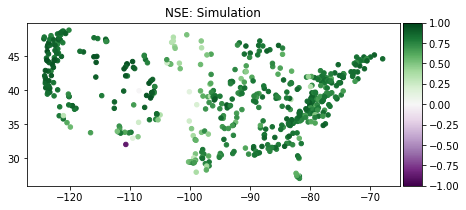

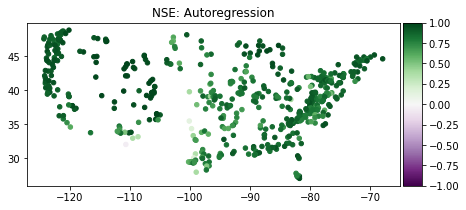

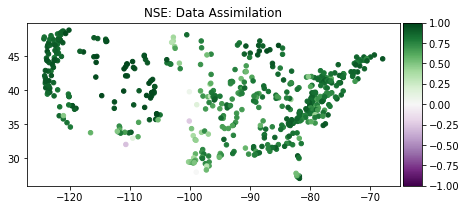

In [34]:
model_label_map = {'nse_da':'Data Assimilation', 'nse_ar':'Autoregression', 'nse_sim':'Simulation'}
for model in ['nse_sim', 'nse_ar', 'nse_da']:
    gs = plt.GridSpec(1, 10, wspace=0.33333)
    fig = plt.figure(figsize=(12, 3))
    ax0 = fig.add_subplot(gs[0,:6])
    im = ax0.scatter(plot_lons, plot_lats,
                    c=df.loc[:,model],
                    s=20,
                    cmap='PRGn',
                    vmin=-1, vmax=1)
    ax0.set_title('NSE: {}'.format(model_label_map[model]))
    clims = im.get_clim()
    
    # colorbar
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')


/home/jmframe/programs/anaconda3/envs/neuralhydrology_da/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


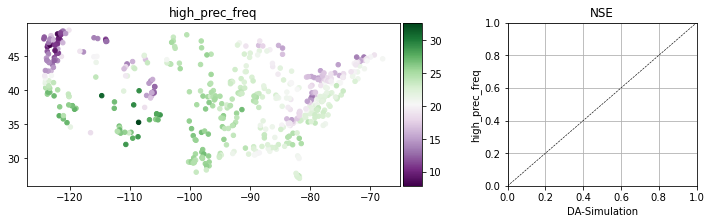

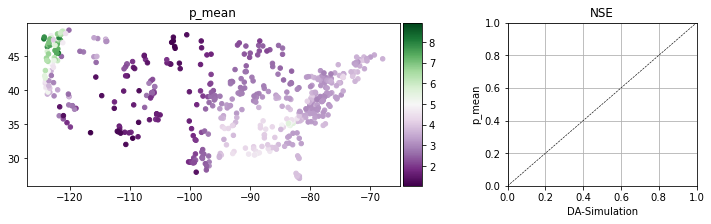

In [35]:
test_model_label_map = {'nse_da':'Data Assimilation', 'nse_ar':'Autoregression'}

for plot_variable in ['high_prec_freq', 'p_mean']:
    
    gs = plt.GridSpec(1, 10, wspace=0.33333)
    fig = plt.figure(figsize=(12, 3))
    ax0 = fig.add_subplot(gs[0,:6])
    im = ax0.scatter(plot_lons, plot_lats,
                    c=df.loc[:,plot_variable],
                    s=20,
                    cmap='PRGn',
                    vmin=np.min(df.loc[:,plot_variable]), vmax=np.max(df.loc[:,plot_variable]))
    ax0.set_title(plot_variable)
    clims = im.get_clim()

    # colorbar
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax1 = fig.add_subplot(gs[0,7:])
    ax1.plot([0, 1],[0,1], 'k--', lw=0.6)
    for b, basin in enumerate(basin_list):
        basin_color = im.to_rgba(df.loc[:,plot_variable])
        ax1.scatter(df.loc[:,'nse_da-sim'],
                    df.loc[:,plot_variable],
                    s=5,
                    color=basin_color)
    ax1.set_title('NSE')
    ax1.set_xlabel('DA-Simulation')
    ax1.set_ylabel(plot_variable)
    ax1.set_xlim([0,1])
    ax1.set_ylim([0,1])
    ax1.grid()

    plt.tight_layout()
    plt.show()
    plt.close()